In [1]:
from torch import nn
from torch.nn import CrossEntropyLoss
import torch.nn.functional as F
import torch
import numpy as np
import sys
sys.path.append("BLIP")
from models.blip import BLIP_Base,load_checkpoint
import json

# Bag-of-Words Classifier

In [2]:
from functools import cache
from collections import deque
from math import log
from typing import Deque,Dict,List,Tuple
import nltk
import random
import string

class BOWClassifier:
    def __init__(self, classes=2) -> None:
        self.classes = classes
        self.bow = [{} for i in range(classes)]
        self.all_words = set()

        self.tot = [0 for i in range(classes)]

    def clean_text(self, text):
        return "".join([c for c in text if c not in string.punctuation and not c.isdigit()])

    def add_text(self, text, cls):
        text = self.clean_text(text)
        words = nltk.word_tokenize(text)
        for word in words:
            word = word.strip().lower()
            if word not in self.bow[cls]:
                self.bow[cls][word] = 0
            
            self.bow[cls][word]+=1
            self.tot[cls] += 1

            self.all_words.add(word)

    def classify(self, text):
        text = self.clean_text(text)
        words = nltk.word_tokenize(text)
        best = (-9999999999999999999, -1)
        for cls,bow in enumerate(self.bow):
            base_log_prob = 0
            base_log_prob += log(self.tot[cls]/sum(self.tot))
            for word in self.all_words:
                freq = self.bow[cls][word]/self.tot[cls] if word in self.bow[cls] else 0
                base_log_prob += log(1.0001-freq)
            for word in words:
                word = word.strip().lower()
                freq = self.bow[cls][word]/self.tot[cls] if word in self.bow[cls] else 0
                base_log_prob -= log(1.0001-freq)
                base_log_prob += log(freq + 0.0001)
            best = max(best, (base_log_prob,cls))

        return best[1]

In [3]:
import pandas

df_dataset = pandas.read_csv("../datasets/main_val.csv", delimiter="\t")
df_train = df_dataset[df_dataset["split"]=="train"]
df_valid = df_dataset[df_dataset["split"]=="valid"]

FileNotFoundError: [Errno 2] No such file or directory: '../datasets/main_val.csv'

In [61]:
from tqdm import tqdm

def validate(tf_idf_knn):
    fp,fn,tp,tn = 0,0,0,0
    for idx, content in df_valid.iterrows():
        result = tf_idf_knn.classify(content["text"])
        if content["label"]==1 and result==1: tp += 1
        if content["label"]==1 and result==0: fn += 1
        if content["label"]==0 and result==1: fp += 1
        if content["label"]==0 and result==0: tn += 1
    return fp,fn,tp,tn

train = list(df_train.iterrows())
random.shuffle(train)

metric_history = []

classifier = BOWClassifier()
for idx,(_,content) in tqdm(list(enumerate(train))):
    classifier.add_text(content["text"], content["label"])

    if idx > 0 and idx%10==0:
        metric_history.append((idx, validate(classifier)))

100%|██████████| 1660/1660 [02:26<00:00, 11.36it/s]


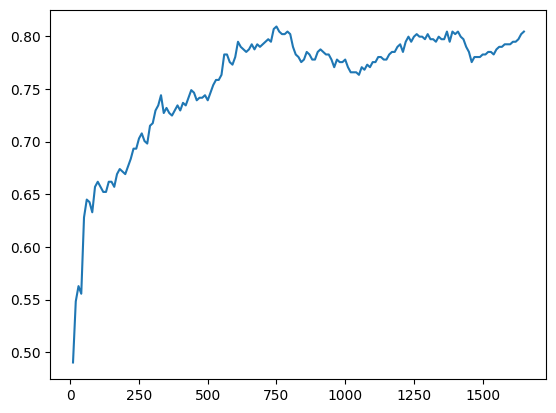

In [62]:
import matplotlib.pyplot as plt

plt.plot([metric[0] for metric in metric_history], [sum(metric[1][2:])/sum(metric[1]) for metric in metric_history])

In [63]:
metric_history

[(10, (135, 76, 134, 69)),
 (20, (129, 58, 152, 75)),
 (30, (55, 126, 84, 149)),
 (40, (46, 138, 72, 158)),
 (50, (55, 99, 111, 149)),
 (60, (50, 97, 113, 154)),
 (70, (51, 97, 113, 153)),
 (80, (52, 100, 110, 152)),
 (90, (40, 102, 108, 164)),
 (100, (43, 97, 113, 161)),
 (110, (52, 90, 120, 152)),
 (120, (56, 88, 122, 148)),
 (130, (54, 90, 120, 150)),
 (140, (55, 85, 125, 149)),
 (150, (62, 78, 132, 142)),
 (160, (61, 81, 129, 143)),
 (170, (60, 77, 133, 144)),
 (180, (56, 79, 131, 148)),
 (190, (56, 80, 130, 148)),
 (200, (59, 78, 132, 145)),
 (210, (62, 72, 138, 142)),
 (220, (59, 72, 138, 145)),
 (230, (54, 73, 137, 150)),
 (240, (52, 75, 135, 152)),
 (250, (49, 74, 136, 155)),
 (260, (52, 69, 141, 152)),
 (270, (54, 70, 140, 150)),
 (280, (51, 74, 136, 153)),
 (290, (52, 66, 144, 152)),
 (300, (52, 65, 145, 152)),
 (310, (51, 61, 149, 153)),
 (320, (53, 57, 153, 151)),
 (330, (52, 54, 156, 152)),
 (340, (64, 49, 161, 140)),
 (350, (64, 47, 163, 140)),
 (360, (64, 49, 161, 140)),

In [64]:
f0,f1 = classifier.bow[0], classifier.bow[1]

In [66]:
cnt=0
for word in f1:
    if word not in f0:
        print(word)
        cnt += 1
cnt

celebrity
billionaire
surgeries
con
mess
campuses
it—again
strawmen
lazy
smooth
brained
amid
antisemitism
gop
governor
recognizes
heritage
smol
penis
lolololol
ded
wonder
deliberately
design
poorly
grassroots
ukraine
berklee
threatening
prochinese
bans
noncompete
agreements
tolerance
virtue
convictions
fellaraktar
caption
🤮
redcaps
racist
comic
shame
democrat
cuellar
indicted
bribery
matter
repost
toughest
battles
toxic
sjw
fandom
points
leftism
resort
appearance
reposted
breyers
blunt
supreme
conservatives
slow
border
killing
bannon
rips
mike
johnson
timing
criminal
conspiracy
investigation
helpful
dems
opening
scott
equivocates
abortion
debate
challenges
bogus
patents
ozempic
spur
competition
lefts
phony
electors
crusade
ramps
nears
trumps
trials
accelerating
countdown
americas
media
lies
democrats
elections
refute
focuses
moldova
semafor
democratic
primary
puerto
rico
shuts
ucla
prohamas
protests
panicked
proterrorist
protesters
counter
begin
attacking
mobbed
unconscious
ignoble
inf

2199

# BLIP Classifier

In [ ]:
from torchvision import transforms
from torchvision.transforms.functional import InterpolationMode

blip_img_size = 224
batch_size = 16

train_transform = transforms.Compose([
    transforms.Resize((blip_img_size,blip_img_size),interpolation=InterpolationMode.BICUBIC),
    transforms.ToTensor(),
    transforms.Normalize((0.48145466, 0.4578275, 0.40821073), (0.26862954, 0.26130258, 0.27577711)),
])
val_transform = train_transform

In [ ]:
from RedditData import *

main_csv_path = "../datasets/main_val.csv"

train_dataset = RedditDataset("../datasets", main_csv=main_csv_path, im_transform=train_transform)
train_sampler = RedditDataSampler("../datasets", main_csv=main_csv_path, upsampling=False)

val_dataset = RedditDataset("../datasets", main_csv=main_csv_path, split="valid", im_transform=val_transform)
val_sampler = RedditDataSampler("../datasets", main_csv=main_csv_path, split="valid")

train_dataloader = DataLoader(train_dataset, batch_sampler=BatchSampler(train_sampler, batch_size, True))
val_dataloader = DataLoader(val_dataset, batch_sampler=BatchSampler(val_sampler, 1, True))